In [1]:
#imports
# !pip install ultralytics -q
from ultralytics import YOLO
import os
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

import shutil
import yaml
from IPython.display import Image


In [2]:
!ls

0001				      runs
0002				      sample_submission.csv
0003				      submission1724529967.csv
0004				      submission1724604221.csv
0005				      submission1724604951.csv
0006				      submission1724629273.csv
0007				      submission1724703590.csv
animal-type-detection-tutorial.ipynb  submission1724704375.csv
datasets			      submission_v101724627780.csv
inference.py			      submission_v101724628234.csv
label_train.csv			      train.ipynb
metric.ipynb			      yolo_dataset
prepare_files.ipynb		      yolov8m.pt
README.md


In [3]:
#load label data
df = pd.read_csv('label_train.csv')
df.head()

,filename,class,xmin,ymin,xmax,ymax
0,cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...,cow,1,54,641,562
1,4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...,cow,168,128,532,360
2,cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...,cow,584,310,586,312
3,97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...,cow,7,62,641,469
4,747cef5f-e7dc-4657-b0e4-225450446a631015105642...,cow,120,48,530,336


In [4]:
df['class'].value_counts(normalize=True)

class
cow     0.704333
pig     0.165376
goat    0.130291
Name: proportion, dtype: float64

In [5]:
df['filename'].duplicated().any()

True

In [6]:
#get file path for image files
df['filepath'] = df.apply(lambda row: glob(f'**/{row.filename}')[0], axis=1)

In [7]:
len(df.filename.unique()), len(df.filepath.unique())

(9808, 9808)

In [8]:
df.head()

,filename,class,xmin,ymin,xmax,ymax,filepath
0,cb3854ef-2abc-4d44-bd1f-807a38660c616894251975...,cow,1,54,641,562,0006/cb3854ef-2abc-4d44-bd1f-807a38660c6168942...
1,4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e804977089514...,cow,168,128,532,360,0003/4f3cbf08-13cc-4ae9-bad0-ea7f4fc96e8049770...
2,cb279fc1-67a3-413c-b3f8-c0594bf0507a1407359993...,cow,584,310,586,312,0006/cb279fc1-67a3-413c-b3f8-c0594bf0507a14073...
3,97e0bf2d-4548-4c25-9bd7-5a867b8654153628120299...,cow,7,62,641,469,0005/97e0bf2d-4548-4c25-9bd7-5a867b86541536281...
4,747cef5f-e7dc-4657-b0e4-225450446a631015105642...,cow,120,48,530,336,0004/747cef5f-e7dc-4657-b0e4-225450446a6310151...


In [9]:
def convert_voc_to_yolo(xmin, ymin, xmax, ymax, img_width=640, img_height=640):
    # Calculate the center of the bounding box
    center_x = (xmin + xmax) / 2.0
    center_y = (ymin + ymax) / 2.0

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Normalize the values by the dimensions of the image
    center_x /= img_width
    center_y /= img_height
    width /= img_width
    height /= img_height

    return [center_x, center_y, width, height]

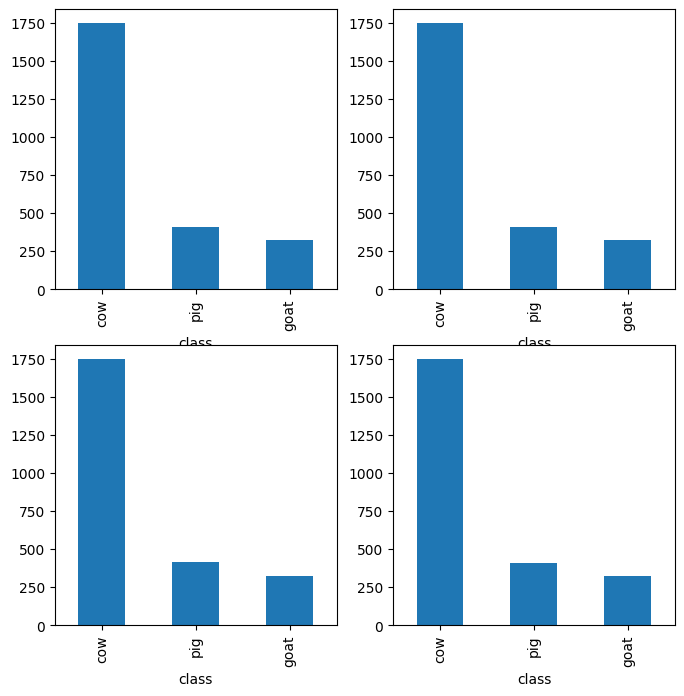

In [10]:
# df_train, df_valid = train_test_split(df, test_size=0.3, random_state=32)


"""
use stratified kfold split to have equal distribution of classes in the folds
"""

df["folds"]= -1

skf = StratifiedKFold(n_splits = 4, random_state=32, shuffle=True)

for i, (train_index, val_index) in enumerate(skf.split(
    df, df["class"]
)
):
    df.loc[val_index, "folds"] = i


"""
Plot the distribution of classes in each fold
"""
fig, axes = plt.subplots(2,2, figsize=(8,8))

axes = axes.flatten()

for i in range(len(axes)):
    # axes[i]
    df[df.folds == i]["class"].value_counts().plot.bar(ax = axes[i])

plt.show()

In [11]:
"""
choose folds 0,1,2 for train and fold 3 for validation
"""


df_train = df[df.folds.isin([0,1,2])]

df_valid = df[df.folds.isin([3])]

In [12]:
labels = ['cow', 'goat', 'pig']

In [13]:
os.makedirs('yolo_dataset/train/labels', exist_ok=True)
os.makedirs('yolo_dataset/train/images', exist_ok=True)
train_grouping = df_train.groupby('filepath')
for index, group in enumerate(train_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/train/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/train/images')

In [14]:
os.makedirs('yolo_dataset/valid/labels', exist_ok=True)
os.makedirs('yolo_dataset/valid/images', exist_ok=True)
valid_grouping = df_valid.groupby('filepath')
for index, group in enumerate(valid_grouping):
    bboxes = group[1].apply(lambda row: [row.xmin, row.ymin, row.xmax, row.ymax] , axis=1).to_list()   
    classes = group[1].apply(lambda row: labels.index(row['class']) , axis=1).to_list() 
    file_path = group[0]
    filename = os.path.basename(file_path)
    with open(f'yolo_dataset/valid/labels/{os.path.splitext(filename)[0]}.txt', 'w') as file:
        for class_, bbox in zip(classes, bboxes):
            center_x, center_y, width, height = convert_voc_to_yolo(*bbox)
            file.write(f'{class_} {center_x} {center_y} {width} {height}\n')
    shutil.copy(file_path, 'yolo_dataset/valid/images')

In [15]:
df_sample_submission = pd.read_csv('sample_submission.csv')
df_sample_submission.head()

,filename,class,confidence,xmin,ymin,xmax,ymax
0,dc3bf168-1589-486d-8152-438d0e4a56f24141622663...,cow,0.75,0,0,0,0
1,0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...,cow,0.75,0,0,0,0
2,68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...,cow,0.75,0,0,0,0
3,57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...,cow,0.75,0,0,0,0
4,7091ebde-40ba-478c-b119-2c558dfe133a8689373316...,cow,0.75,0,0,0,0


In [16]:
#get file path for test image files
df_sample_submission['filepath'] = df_sample_submission.apply(lambda row: glob(f'**/{row.filename}')[0], axis=1)
df_sample_submission.head()

,filename,class,confidence,xmin,ymin,xmax,ymax,filepath
0,dc3bf168-1589-486d-8152-438d0e4a56f24141622663...,cow,0.75,0,0,0,0,0006/dc3bf168-1589-486d-8152-438d0e4a56f241416...
1,0691e0da-6b49-414e-a0d9-e6caa2fbe3fa2720742594...,cow,0.75,0,0,0,0,0001/0691e0da-6b49-414e-a0d9-e6caa2fbe3fa27207...
2,68072e08-d602-4daa-9b2e-b53e3075d45d7996898967...,cow,0.75,0,0,0,0,0003/68072e08-d602-4daa-9b2e-b53e3075d45d79968...
3,57f59f63-9ec6-4d0b-b837-808a089f3d876691836245...,cow,0.75,0,0,0,0,0003/57f59f63-9ec6-4d0b-b837-808a089f3d8766918...
4,7091ebde-40ba-478c-b119-2c558dfe133a8689373316...,cow,0.75,0,0,0,0,0004/7091ebde-40ba-478c-b119-2c558dfe133a86893...


In [17]:
test_file_paths = df_sample_submission.filepath.unique()

In [20]:
#create test directory
os.makedirs('yolo_dataset/test/images', exist_ok=True)
for file_path in test_file_paths:
    shutil.copy(file_path, 'yolo_dataset/test/images')

In [21]:
data = {
'names': labels,
'nc': len(labels),
'test': './test/images',
'train': './train/images',
'val': './valid/images'
}
with open('yolo_dataset/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)